In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('course_lead_scoring.csv')

In [4]:
df.head(30)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
5,events,manufacturing,1,59904.0,NaN,africa,6,0.83,1
6,social_media,technology,0,51283.0,NaN,middle_east,2,0.57,0
7,social_media,NaN,5,62975.0,student,europe,4,0.62,1
8,referral,healthcare,4,38648.0,unemployed,south_america,2,0.86,1
9,paid_ads,other,3,59866.0,student,australia,3,0.43,1


In [5]:
df.isnull().sum()
df.dtypes
df.shape

(1462, 9)

In [6]:
numerical_columns = df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index
numerical_columns

categorical_columns = df.dtypes[(df.dtypes == 'object')].index
categorical_columns

categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count',
       'lead_score', ]

In [7]:
numerical, categorical

(['number_of_courses_viewed',
  'annual_income',
  'interaction_count',
  'lead_score'],
 ['lead_source', 'industry', 'employment_status', 'location'])

In [8]:
for c in categorical:
    df[c] =df[c].str.lower().str.replace(' ','_')
    df[c] = df[c].fillna('NA')

for c in numerical:
    df[c] = df[c].fillna(0) 

In [9]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [10]:
df_full_train , df_test = train_test_split(df, test_size=0.2, random_state = 1)

In [11]:
len(df_full_train), len(df_test)

(1169, 293)

In [12]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val)

(876, 293)

In [13]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [14]:
y_full_train = df_full_train.converted.values
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [15]:
del df_train['converted']
del df_val['converted']
del df_test['converted']


ONE HOT ENCODING DICTVECTORIZER


When you train a logistic regression model, the computer tries to find the best-fitting line (or curve) that separates the classes (for example, customers who converted vs. those who didn’t). To do that, it uses a solver — an algorithm that keeps adjusting the model’s internal numbers until the fit stops improving.

Think of “iterations” as how many times the solver is allowed to adjust and check its work. Hence max_iter = 1000

Different solvers use different “strategies” for fitting.
'lbfgs' (the default) works well for large or continuous datasets but can get stuck when features vary widely in scale.
'liblinear' is a simpler, more stable solver that works better with small to medium datasets and binary classification problems (like this project).

In [91]:
dv = DictVectorizer(sparse = False)
train_dict = df_train[categorical + numerical ].to_dict(orient='records')
x_train = dv.fit_transform(train_dict)
model = LogisticRegression(solver='liblinear',C=1.0, max_iter=1000)
model.fit(x_train,y_train)

# y_train_pred = model.predict_proba(x_train)[:,1]


LogisticRegression(max_iter=1000, solver='liblinear')

In [96]:
from sklearn.metrics import roc_auc_score


auc_scores = {}
for feature in numerical:
    if feature in df_train.columns:
        auc = roc_auc_score(y_train, df_train[feature])
        if auc < 0.5:
            auc = roc_auc_score(y_train, -df_train[feature])
        auc_scores[feature] = auc
        print(f"{feature}: {auc:.4f}")
        
best_feature = max(auc_scores, key=auc_scores.get)
print(f"\nBest feature: {best_feature} with AUC = {auc_scores[best_feature]:.4f}")

number_of_courses_viewed: 0.7636
annual_income: 0.5520
interaction_count: 0.7383
lead_score: 0.6145

Best feature: number_of_courses_viewed with AUC = 0.7636


Accuracy

In [97]:
dict_val = df_val[categorical + numerical].to_dict(orient = 'records')


x_val = dv.transform(dict_val)
y_pred = model.predict_proba(x_val)[:,1] #returns probabilities for both classes (shape: (n_samples, 2)).
churn_decision = y_pred>=0.57

accuracyofthemodel=(y_val == churn_decision).mean()


auc_score_val = roc_auc_score(y_val, y_pred)
auc_score_val, accuracyofthemodel
#from collections import Counter

#counter is used to count number of trues and false in an array

(0.8171316268814112, 0.7542662116040956)

'Best threshold: 0.570, Best score: 0.754'

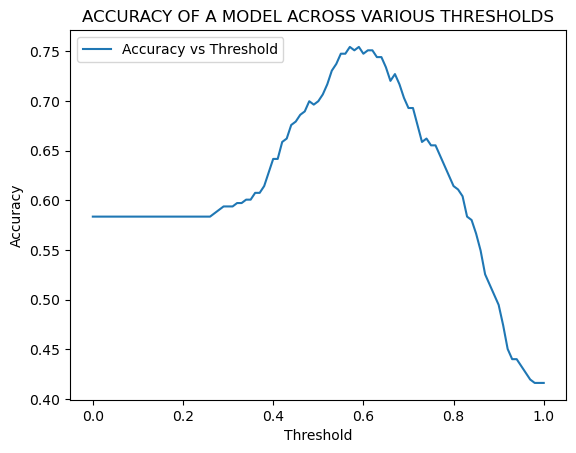

In [99]:
from sklearn.metrics import accuracy_score
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

scores = []
thresholds = np.linspace(0, 1, 101)

best_score = 0
best_threshold = 0

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = accuracy_score(y_val, churn_decision)
    scores.append(score)

    if score > best_score:
        best_score = score
        best_threshold = t

display(f"Best threshold: {best_threshold:.3f}, Best score: {best_score:.3f}")

plt.plot(thresholds, scores, label='Accuracy vs Threshold')
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("ACCURACY OF A MODEL ACROSS VARIOUS THRESHOLDS")
plt.legend()
plt.show()


In [100]:
from sklearn.metrics import roc_auc_score
from IPython.display import display

auc_scores = []
for n in numerical:
    auc = roc_auc_score(y_train, df_train[n])
    if auc < 0.5:
            auc = roc_auc_score(y_train, -df_train[n]) #invert it coz auc cannot be below that of the random model
    auc_scores.append(auc)
    display(auc, n)


0.7635680590007088

'number_of_courses_viewed'

0.5519578313253012

'annual_income'

0.738270176293409

'interaction_count'

0.6144993577250176

'lead_score'


PRECISION AND RECAL

'Estimated intersection point: 0.642'

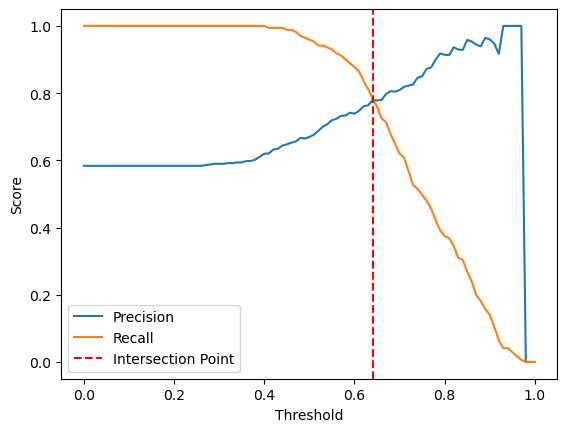

In [103]:
from IPython.display import display

thresholds = np.linspace(0, 1, 101)
precisions = []
recalls = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
  
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    precisions.append(precision)
    recalls.append(recall)

# Convert lists to arrays for math operations
precisions = np.array(precisions)
recalls = np.array(recalls)

# Compute the difference between precision and recall
# Find indices where the difference changes sign (curve intersection)
# If the result is positive, precision is higher than recall.
# If negative, recall is higher than precision.
# When the value is zero, they are equal (that’s the intersection point)
diff = precisions - recalls


#np.sign(diff) ->This converts each value in diff into its signie pos or neg.
#np.diff() -> This shows where the sign changes. a non zero value like -2 or 2 means the sign changed
#np.where()-> returns the indices where a condition is true. This gives the index positions in the threshold("cut off point") list where precision and recall crossed.
#Adding [0] just extracts the first array of indices from the tuple returned by np.where.
sign_changes = np.where(np.diff(np.sign(diff)))[0]

if len(sign_changes) > 0: #checks if the index returned is non-zero or not
    i = sign_changes[0] #takes the 1st index of the returned array
    # Linear interpolation between two nearest points
    t1, t2 = thresholds[i], thresholds[i+1] #unpacks t1 and t2 from the threshold list where precision and recall crossed
    d1, d2 = diff[i], diff[i+1] #unpacks the differences
    #This uses linear interpolation to find the exact threshold where precision = recall (where difference = 0).
    intersection_point = t1 - d1 * (t2 - t1) / (d2 - d1)
else:
    #If precision never exactly equals recall, it picks the threshold where their difference is smallest — the “closest approach.”
    #np.argmin() returns the index of the smallest value in an array.
    #So here it finds the index where the absolute difference between precision and recall is smallest.
    intersection_point = thresholds[np.argmin(abs(diff))]

display(f"Estimated intersection point: {intersection_point:.3f}")

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.axvline(x=intersection_point, color='red', linestyle='--', label='Intersection Point')
plt.legend()
plt.show()


In [61]:
f1_scores = []
for i in range(len(thresholds)):
    p = precisions[i]
    r = recalls[i]
    if p + r > 0:
        f1 = 2 * (p * r) / (p + r)
    else:
        f1 = 0
    f1_scores.append(f1)

max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_value = f1_scores[max_f1_idx]

print(f"Maximum F1 score: {max_f1_value:.4f}")
print(f"Threshold at maximum F1: {max_f1_threshold:.2f}")


Maximum F1 score: 0.8125
Threshold at maximum F1: 0.57


In [69]:
from sklearn.model_selection import KFold


In [71]:
# Prepare full training data
df_full_train_features = df_full_train.drop('converted', axis=1)
y_full_train = df_full_train['converted'].values

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train_features), 1):
    # Split data
    df_fold_train = df_full_train_features.iloc[train_idx]
    df_fold_val = df_full_train_features.iloc[val_idx]
    y_fold_train = y_full_train[train_idx]
    y_fold_val = y_full_train[val_idx]
    
    # Convert to dictionaries and vectorize
    fold_train_dicts = df_fold_train.to_dict(orient='records')
    fold_val_dicts = df_fold_val.to_dict(orient='records')
    
    dv_fold = DictVectorizer(sparse=False)
    X_fold_train = dv_fold.fit_transform(fold_train_dicts)
    X_fold_val = dv_fold.transform(fold_val_dicts)
    
    # Train model
    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(X_fold_train, y_fold_train)
    
    # Evaluate
    y_fold_pred = model_fold.predict_proba(X_fold_val)[:, 1]
    auc_fold = roc_auc_score(y_fold_val, y_fold_pred)
    cv_scores.append(auc_fold)
    
    print(f"Fold {fold}: AUC = {auc_fold:.4f}")

mean_auc = np.mean(cv_scores)
std_auc = np.std(cv_scores)

print(f"\nMean AUC: {mean_auc:.4f}")
print(f"Std AUC: {std_auc:.4f}")

Fold 1: AUC = 0.8061
Fold 2: AUC = 0.8714
Fold 3: AUC = 0.7754
Fold 4: AUC = 0.8018
Fold 5: AUC = 0.8558

Mean AUC: 0.8221
Std AUC: 0.0358


In [106]:

C_values = [0.000001, 0.001, 1]
results = []

for C in C_values:
    cv_scores_c = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train_features), 1):
        # Split data
        df_fold_train = df_full_train_features.iloc[train_idx]
        df_fold_val = df_full_train_features.iloc[val_idx]
        y_fold_train = y_full_train[train_idx]
        y_fold_val = y_full_train[val_idx]
        
        # Convert to dictionaries and vectorize
        fold_train_dicts = df_fold_train.to_dict(orient='records')
        fold_val_dicts = df_fold_val.to_dict(orient='records')
        
        dv_fold = DictVectorizer(sparse=False)
        X_fold_train = dv_fold.fit_transform(fold_train_dicts)
        X_fold_val = dv_fold.transform(fold_val_dicts)
        
        # Train model with C parameter
        model_fold = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_fold.fit(X_fold_train, y_fold_train)
        
        # Evaluate
        y_fold_pred = model_fold.predict_proba(X_fold_val)[:, 1]
        auc_fold = roc_auc_score(y_fold_val, y_fold_pred)
        cv_scores_c.append(auc_fold)
    
    mean_score = np.mean(cv_scores_c)
    std_score = np.std(cv_scores_c)
    results.append({'C': C, 'mean': mean_score, 'std': std_score})
    
    print(f"C = {C}: mean = {mean_score:.3f}, std = {std_score:.3f}")

# Find best C
print()
print("SUMMARY OF RESULTS")
print("="*50)

results_df = pd.DataFrame(results)
print(results_df)

# Best C: highest mean, then lowest std, then smallest C
best_result = results_df.sort_values(['mean', 'std', 'C'], ascending=[False, True, True]).iloc[0]
print(f"\nBest C: {best_result['C']}")
print(f"Mean: {best_result['mean']:.3f}")
print(f"Std: {best_result['std']:.3f}")

print()


C = 1e-06: mean = 0.560, std = 0.024
C = 0.001: mean = 0.867, std = 0.029
C = 1: mean = 0.822, std = 0.036

SUMMARY OF RESULTS
          C      mean       std
0  0.000001  0.560208  0.023798
1  0.001000  0.866878  0.028746
2  1.000000  0.822109  0.035807

Best C: 0.001
Mean: 0.867
Std: 0.029

